In [623]:
import seaborn as sns
import sdeint
import matplotlib.pyplot as plt
import pandas as pd
import sympy as smp
from time import perf_counter
from itertools import combinations
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.optimize import fsolve
import pycatch22 as catch22
from sympy import real_roots
from scipy.stats import pearsonr
import scipy
import statistics
import scipy.cluster.hierarchy as sch
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, FunctionTransformer
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.decomposition import PCA, FactorAnalysis
from scipy.spatial.distance import pdist, squareform, cdist

In [2]:
def gen_limitCycle(num_samples): # num samples
    # hopf
    eta_val_hopf = np.random.uniform(0.01, 0.7, size=num_samples)
    mu_val_hopf = np.random.uniform(0.01, 5, size=num_samples)
    sols_list = list()
    dt = 0.01
    tspan = np.arange(0, 55, dt)
    print('Generating Limit Cycle Instances...')
    for i in range(num_samples):
        mu = mu_val_hopf[i]
        eta = eta_val_hopf[i]
        def f(state, t):
            x, y = state[0], state[1]
            dxdt = -y + (mu - x**2 - y**2) * x
            dydt = x + (mu - x **2 - y **2) * y
            return dxdt, dydt
        ic = np.array(np.random.uniform(size=2))
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        sols_list.append(sol[500:])
    ts_hopf = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_hopf = np.array([catch22.catch22_all(ts_hopf[i,:])['values'] for i in range(len(ts_hopf))])
    df = pd.DataFrame(features_hopf)
    df['mu'] = mu_val_hopf
    df['eta'] = eta_val_hopf
    df['regime'] = 'HopfLC'
    return ts_hopf, df

In [3]:
def gen_fixedpoint(num_samples):
    num_samples = round(num_samples/3)
    if num_samples % 2 == 1:
        num_samples = num_samples + 1
    
    #system 1 - hookes
    eta_val_hookes = np.random.uniform(0.01, 1, size=num_samples)
    mu_val_hookes = np.random.uniform(-1.1, -0.98, size=num_samples)
    sols_list = list()
    dt = 0.01
    tspan = np.arange(0, 55, dt)
    print('Generating Fixed Point Instances...')
    for i in range(num_samples):
        mu = mu_val_hookes[i]
        eta = eta_val_hookes[i]
        def f(state, t):
            x = state[0]
            dxdt = mu *x
            return dxdt
        ic = np.array([np.random.uniform()])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array([ic]), tspan)
        sols_list.append(sol[500:])
    ts_hookes = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_hookes = np.array([catch22.catch22_all(ts_hookes[i,:])['values'] for i in range(len(ts_hookes))])
    df_hookes = pd.DataFrame(features_hookes)
    df_hookes['mu'] = mu_val_hookes
    df_hookes['eta'] = eta_val_hookes
    df_hookes['regime'] = 'HookesFP'

    # system 2 - hopf 
    eta_val_hopf = np.random.uniform(0.01, 1, size=num_samples)
    mu_val_hopf = np.random.uniform(-5, -0.01, size=num_samples) # sample 
    sols_list = list()
    dt = 0.01
    tspan = np.arange(0, 55, dt)
    for i in range(num_samples):
        mu = mu_val_hopf[i]
        eta = eta_val_hopf[i]
        def f(state, t):
            x, y = state[0], state[1]
            dxdt = -y + (mu - x**2 - y**2) * x
            dydt = x + (mu - x **2 - y **2) * y
            return dxdt, dydt
        ic = np.array(np.random.uniform(size=2))
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        sols_list.append(sol[500:])
    ts_hopf = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_hopf = np.array([catch22.catch22_all(ts_hopf[i,:])['values'] for i in range(len(ts_hopf))])
    df_hopf = pd.DataFrame(features_hopf)
    df_hopf['mu'] = mu_val_hopf
    df_hopf['eta'] = eta_val_hopf
    df_hopf['regime'] = 'HopfFP'

    # system 3 - bistable
    eta_val_bistable = np.random.uniform(0.01, 1, size=num_samples)
    mu_val_bistable = np.concatenate([np.random.uniform(-5, -0.385, size=int(num_samples/2)), np.random.uniform(0.385, 5, size=int(num_samples/2))])
    sols_list = list()
    dt = 0.01
    tspan = np.arange(0, 55, dt)
    for i in range(num_samples):
        mu = mu_val_bistable[i]
        eta = eta_val_bistable[i]
        def f(state, t):
            x = state
            dxdt = mu + x - x**3
            return dxdt
        ic = np.array([np.random.uniform()])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        sols_list.append(sol[500:])
    ts_bistable = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_bistable = np.array([catch22.catch22_all(ts_bistable[i,:])['values'] for i in range(len(ts_bistable))])
    df_bistable = pd.DataFrame(features_bistable)
    df_bistable['mu'] = mu_val_bistable
    df_bistable['eta'] = eta_val_bistable
    df_bistable['regime'] = 'BistableFP'

    ts_fixedpt = np.vstack([ts_hookes, ts_hopf, ts_bistable])
    df_fixedpt = pd.concat([df_hookes, df_hopf, df_bistable])


    return ts_fixedpt, df_fixedpt

In [4]:
def gen_switching(num_samples):
    eta_val_bistable = list()
    mu_val_bistable = list()
    sols_list = list()
    dt = 0.01
    tspan = np.arange(0, 55, dt)
    count = 0 
    print('Generating Bistable Switching Instances...')
    while count < num_samples:
        mu = np.random.uniform(low=-0.38487849, high=0.38487849)
        eta = np.random.uniform(0.001, 1)
        def f(state, t):
            x = state
            dxdt = mu + x - x**3
            return dxdt
        ic = np.array([np.random.uniform()])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        X = smp.Symbol('x', real=True)
        eq = mu + X - X**3
        roots = [j.n(6) for j in real_roots(eq, X)]
        max_root = np.max(roots)
        min_root = np.min(roots)
        max_actual = np.max(sol[500:])
        min_actual = np.min(sol[500:])
        # check for switching condition
        if (max_actual >= max_root) & (min_actual <= min_root):
            eta_val_bistable.append(eta)
            mu_val_bistable.append(mu)
            sols_list.append(sol[500:])
            count += 1
    ts_bistable = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_bistable = np.array([catch22.catch22_all(ts_bistable[i,:])['values'] for i in range(len(ts_bistable))])
    df = pd.DataFrame(features_bistable)
    df['mu'] = mu_val_bistable
    df['eta'] = eta_val_bistable
    df['regime'] = 'BistableSW'
    return ts_bistable, df

In [207]:
def select_representative_instances(subset_target_size, ts, df, x0=0.1):
    # takes in target number of instances, uses hierarchical clustering to find most representative samples
    # returns dataframe and ts of selected subset
    # x0 is the initial guess for fsolve
    normalized_features = StandardScaler().fit_transform(df.iloc[:,:22]) # extract the features from df and standardise
    Z = linkage(normalized_features, method='ward')
    def calc_clusters(max_d):
        clusters = fcluster(Z, max_d, criterion='distance')
        num_clusters = np.max(clusters)
        return subset_target_size - num_clusters
    res = fsolve(calc_clusters, x0=x0)
    clusters = fcluster(Z, res, criterion='distance')
    num_clusters = np.max(clusters)
    subset_index = list() # store indicies of the selected instances from each cluster
    for i in range(1, num_clusters+1):
        cluster_indicies = np.argwhere(clusters == i).reshape(-1,) # get all samples in each cluster
        if len(cluster_indicies) > 1:
            # select the most representative instance that minimizes sum of pairwise distances
            ary = cdist(df.iloc[cluster_indicies, :22], df.iloc[cluster_indicies, :22], metric='euclidean')
            most_representative = np.sum(ary, axis=1).argmin()
            most_rep_index = cluster_indicies[most_representative]
        else:
            most_rep_index = cluster_indicies.reshape(-1,)[0]
        subset_index.append(most_rep_index)
    # reduced ts and df for the selected subset
    ts_reduced = ts[subset_index]
    df_reduced = df.iloc[subset_index] # retains original index number
    
    return ts_reduced, df_reduced

In [804]:
samples_per_class = 10000
ts_sw, df_sw = gen_switching(samples_per_class)
ts_fp, df_fp = gen_fixedpoint(samples_per_class)
ts_lc, df_lc = gen_limitCycle(samples_per_class)

Generating Bistable Switching Instances...
Generating Fixed Point Instances...
Generating Limit Cycle Instances...


In [805]:
X = np.vstack([df_fp.iloc[:,:22], df_lc.iloc[:,:22], df_sw.iloc[:,:22]])
# GROUND TRUTH LABELS
y = np.concatenate([np.tile(0, len(df_fp)), np.tile(1, len(df_lc)), np.tile(2, len(df_sw))]) # 0 = FP, 1 = LC, 2 = BS

In [988]:
ts_sw_sub, df_sw_sub = select_representative_instances(1000, ts_sw, df_sw, x0=0.5)
ts_fp_sub, df_fp_sub = select_representative_instances(1000, ts_fp, df_fp, x0=0.5)
ts_lc_sub, df_lc_sub = select_representative_instances(1000, ts_lc, df_lc, x0=0.5)

In [989]:
X_sub = np.vstack([df_fp_sub.iloc[:,:22], df_lc_sub.iloc[:,:22], df_sw_sub.iloc[:,:22]])
# GROUND TRUTH LABELS
y_sub = np.concatenate([np.tile(0, len(df_fp_sub)), np.tile(1, len(df_lc_sub)), np.tile(2, len(df_sw_sub))]) # 0 = FP, 1 = LC, 2 = BS

In [576]:
def MixedSig(X):
    iqrX = scipy.stats.iqr(X, axis=0) # compute interquartile range
    Xhat = X
    for index, iqr in enumerate(iqrX):
        if iqr == 0:
            # apply standard logistic sigmoid
            meanX = np.mean(X[:, index])
            stdX = np.std(X[:, index])
            Xhat[:, index] = 1./(1+np.exp(-(X[:, index]-meanX)/stdX))
        else:
            # apply outlier robust sigmoid
            medianX = np.median(X[:, index])
            Xhat[:, index] = 1./(1 + np.exp(-(X[:, index]-medianX)/(1.35*iqrX[index])))
    
    # rescale to unit interval
    minX = np.min(Xhat, axis=0)
    maxX = np.max(Xhat, axis=0)

    Xhat = (Xhat - minX)/(maxX-minX)
    
    return Xhat

In [577]:
MixedSigmoid = FunctionTransformer(MixedSig)

In [990]:
sig = MixedSigmoid.fit(X_sub)
X_hat = sig.transform(X_sub)

In [991]:
pca_fit = PCA(n_components=2).fit(X_hat)
pca = pca_fit.transform(X_hat)

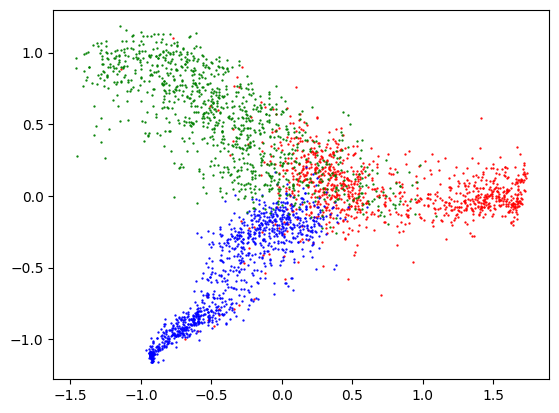

In [992]:
plt.scatter(pca[y_sub==0,0], pca[y_sub==0,1], c='r', label='Fixed Point', s=0.4)
plt.scatter(pca[y_sub==1,0], pca[y_sub==1,1], c='b', label='Limit Cycle', s=0.4)
plt.scatter(pca[y_sub==2,0], pca[y_sub==2,1], c='g', label='Bistable Switching', s=0.4)

Generate validation data for testing

In [1025]:
ts_validate_lc, df_validate_lc = gen_limitCycle(500)
ts_validate_fp, df_validate_fp = gen_fixedpoint(500)
ts_validate_sw, df_validate_sw = gen_switching(500)

Generating Limit Cycle Instances...
Generating Fixed Point Instances...
Generating Bistable Switching Instances...


In [1030]:
validation_data = pd.concat([df_validate_fp.iloc[:,:22], df_validate_lc.iloc[:,:22], df_validate_sw.iloc[:,:22]])
validation_data_labels = np.concatenate([np.tile(0, len(df_validate_fp)), np.tile(1, len(df_validate_lc)), np.tile(2, len(df_validate_sw))]) # 0 = FP, 1 = LC, 2 = BS

In [1031]:
validation_data_hat = sig.transform(validation_data.to_numpy())
val_data_embeddings = pca_fit.transform(validation_data_hat)

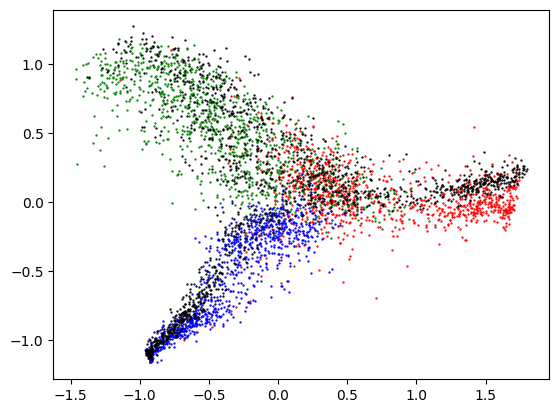

In [1032]:
plt.scatter(pca[y_sub==0,0], pca[y_sub==0,1], c='r', label='Fixed Point', s=0.4)
plt.scatter(pca[y_sub==1,0], pca[y_sub==1,1], c='b', label='Limit Cycle', s=0.4)
plt.scatter(pca[y_sub==2,0], pca[y_sub==2,1], c='g', label='Bistable Switching', s=0.4)

plt.scatter(val_data_embeddings[validation_data_labels==0,0], val_data_embeddings[validation_data_labels==0,1], c='k', label='Fixed Point', s=0.4)
plt.scatter(val_data_embeddings[validation_data_labels==1,0], val_data_embeddings[validation_data_labels==1,1], c='k', label='Limit Cycle', s=0.4)
plt.scatter(val_data_embeddings[validation_data_labels==2,0], val_data_embeddings[validation_data_labels==2,1], c='k', label='Bistable Switching', s=0.4)

Now exclude all instances near the centre -> if theory is true, then second peak will be supressed

In [994]:
centre = [0.2, 0.2]
radius = 0
idx = np.argwhere(np.linalg.norm(centre - val_data_embeddings, axis=1) > radius)
val_data_subset = val_data_embeddings[idx].reshape(-1, 2)
val_data_subset_labels = validation_data_labels[idx].reshape(-1,)

Text(0, 0.5, 'PC2')

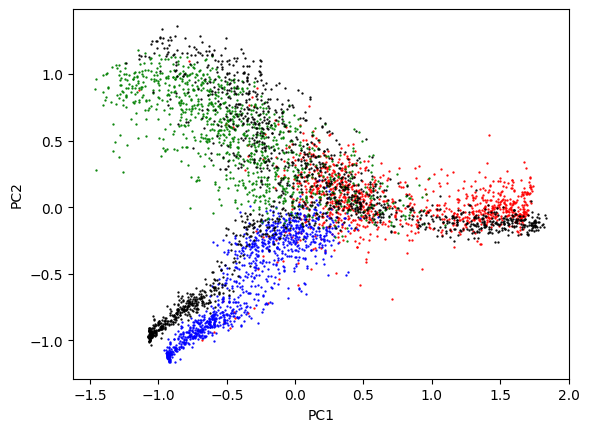

In [995]:
fig, ax = plt.subplots()

ax.scatter(pca[y_sub==0,0], pca[y_sub==0,1], c='r', label='Fixed Point', s=0.4)
ax.scatter(pca[y_sub==1,0], pca[y_sub==1,1], c='b', label='Limit Cycle', s=0.4)
ax.scatter(pca[y_sub==2,0], pca[y_sub==2,1], c='g', label='Bistable Switching', s=0.4)

ax.scatter(val_data_subset[val_data_subset_labels==0,0], val_data_subset[val_data_subset_labels==0,1], c='k', label='Fixed Point', s=0.4)
ax.scatter(val_data_subset[val_data_subset_labels==1,0], val_data_subset[val_data_subset_labels==1,1], c='k', label='Limit Cycle', s=0.4)
ax.scatter(val_data_subset[val_data_subset_labels==2,0], val_data_subset[val_data_subset_labels==2,1], c='k', label='Bistable Switching', s=0.4)

draw_circle = plt.Circle( (0.2, 0.2 ), radius,fill = False)
ax.add_artist(draw_circle)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')


In [999]:
epsilons = np.linspace(0.3, 2, 100) # scan across proposed epsilon values
# store num correct for each epsilon
accuracies = list()
for epsilon in epsilons:
    # cycle through N validation samples
    predictions = list()
    for test_point in val_data_subset: 
        # pca_subset
        neighbours = np.argwhere(np.linalg.norm(pca - test_point, axis=1) < epsilon)
        neighbours = y_sub[neighbours] # get labels of neighbouring points
        unique, counts = np.unique(neighbours, return_counts=True)
        pred = unique[np.argmax(counts)]
        predictions.append(pred)
    matches = np.count_nonzero(predictions == val_data_subset_labels)
    accuracy = matches/len(val_data_subset_labels)
    accuracies.append(accuracy)

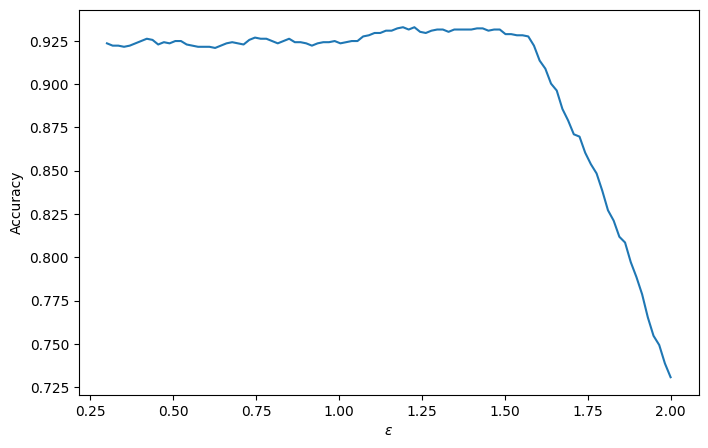

In [1000]:
plt.figure(figsize=(8,5))
plt.plot(epsilons, accuracies)
plt.xlabel(r'$\epsilon$')
plt.ylabel('Accuracy')
plt.show()

In [986]:
epsilons[np.argmax(accuracies)]

0.09919191919191919

We will now inspect the point density as a function of radius for a single point near the centre to get a better understanding of how the classification accuracy evolves with radius.

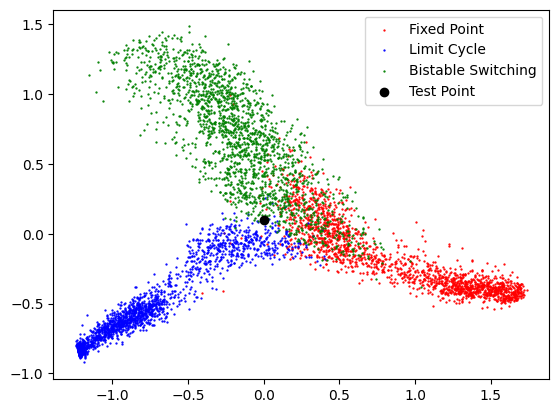

In [800]:
plt.scatter(pca[y_sub==0,0], pca[y_sub==0,1], c='r', label='Fixed Point', s=0.4)
plt.scatter(pca[y_sub==1,0], pca[y_sub==1,1], c='b', label='Limit Cycle', s=0.4)
plt.scatter(pca[y_sub==2,0], pca[y_sub==2,1], c='g', label='Bistable Switching', s=0.4)

fake_embedding = np.array([0, .1])
plt.scatter(fake_embedding[0], fake_embedding[1], c='k', label='Test Point')
plt.legend()
plt.show()

In [801]:
r = np.linspace(0.05, 4, 100)
raw_counts_per_radius = list()
for radius in r:
    neighbours = np.argwhere(np.linalg.norm(pca - fake_embedding, axis=1) < radius)
    neighbours = y_sub[neighbours] # get labels of neighbouring points
    unique, counts = np.unique(neighbours, return_counts=True)
    raw_counts = np.zeros((1, 3)) # index 0 = FP, index 1 = LC, index 2 = BS
    for index, val in enumerate(unique):
        raw_counts[0, val] = counts[index]
    raw_counts_per_radius.append(raw_counts)
raw_counts = np.vstack([raw_counts_per_radius]).reshape(-1,3).astype(int)

In [802]:
sums = np.sum(raw_counts, axis=1)
densities = raw_counts/sums[:,np.newaxis] # normalize rows

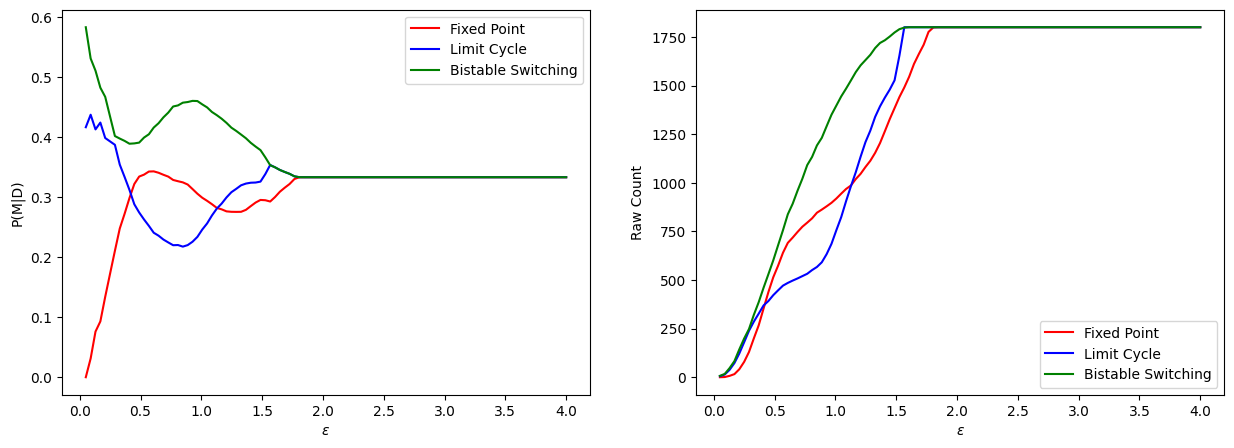

In [803]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].plot(r, densities[:,0], label='Fixed Point', c='r')
ax[0].plot(r, densities[:,1], label='Limit Cycle', c='b')
ax[0].plot(r, densities[:,2], label='Bistable Switching', c='g')
ax[0].set_xlabel(r'$\epsilon$')
ax[0].set_ylabel('P(M|D)')
ax[0].legend()

ax[1].plot(r, raw_counts[:,0], label='Fixed Point', c='r')
ax[1].plot(r, raw_counts[:,1], label='Limit Cycle', c='b')
ax[1].plot(r, raw_counts[:,2], label='Bistable Switching', c='g')
ax[1].set_xlabel(r'$\epsilon$')
ax[1].set_ylabel('Raw Count')
ax[1].legend()

plt.show()

------------------

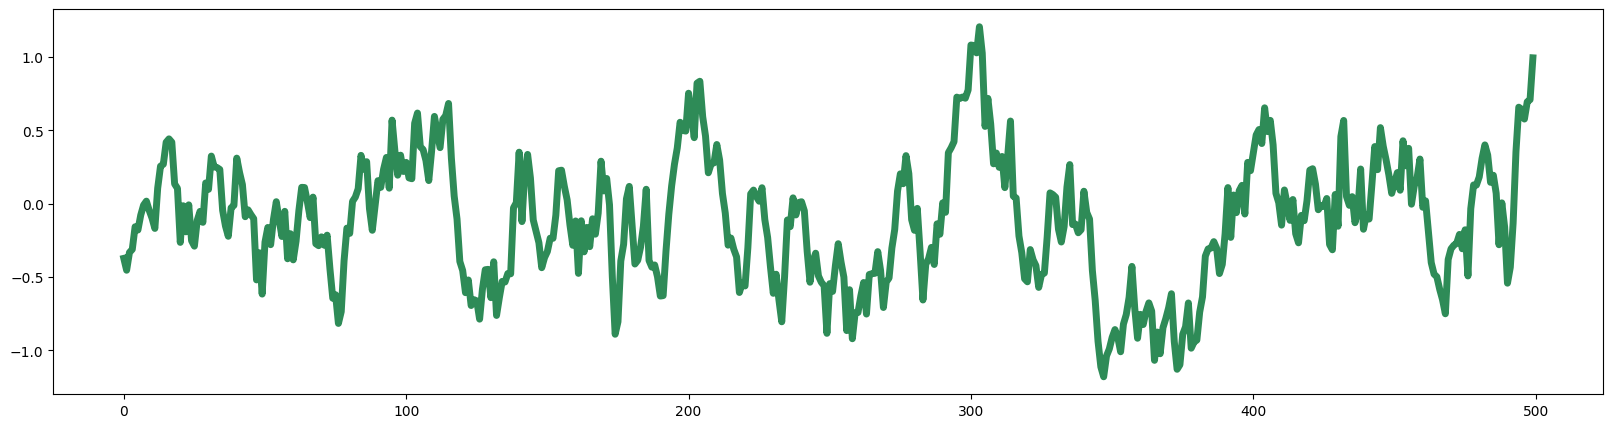

In [1024]:
# light coral | cornflower blue | seagreen
plt.figure(figsize=(20,5))
index = 150
sample = 10
sns.lineplot(x=np.arange(0, 5000/sample), y=ts_fp[80][0::sample], c='seagreen', linewidth=5)
plt.savefig('noisyfp.svg')